<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/6_NN_DeepLearning/ITLFunAPI_tf2_mnist_custom_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar base de datos MNIST

In [0]:
#librerias principales
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier #wrapper keras sklearn
import tensorflow_probability as tfp

In [2]:
#cargar datos
(Xtrain, ytrain), (Xtest, ytest) = tf.keras.datasets.mnist.load_data()
Xtrain = Xtrain/255 #obligar a flotante normalizado 0 a 1
Xtest = Xtest/255
print(Xtrain.shape, Xtest.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


# Función de perdida propia

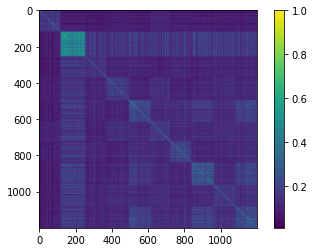

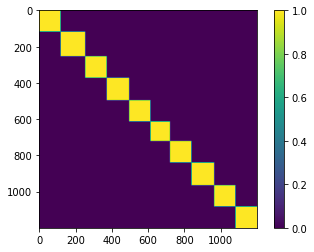

(1200, 1200)


In [3]:
#ejmplo calculos tfp
import tensorflow_probability as tfp
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
#ejemplo cálculo kernels con tfp
Xtraini, _, ytraini, _= train_test_split(Xtrain,ytrain,test_size=0.98, stratify=ytrain)
ind = np.argsort(ytraini)
Xtraini = Xtraini[ind]
ytraini = ytraini[ind]
#lb = LabelBinarizer()
#ytrainb = lb.fit_transform(ytraini)

xi = tf.convert_to_tensor(Xtraini.reshape(Xtraini.shape[0],-1),dtype=tf.float32)
yi = tf.convert_to_tensor(ytraini.reshape(-1,1),dtype=tf.float32)
#kernel gaussiano tfp
scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=5)
scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=1e-13)
K = scalar_kernel.matrix(xi, xi)
plt.imshow(K.numpy())
plt.colorbar()
plt.show()

Ky = scalar_kernely.matrix(yi, yi)
plt.imshow(Ky.numpy())
plt.colorbar()
plt.show()
print(K.shape)

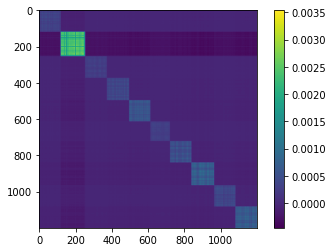

1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


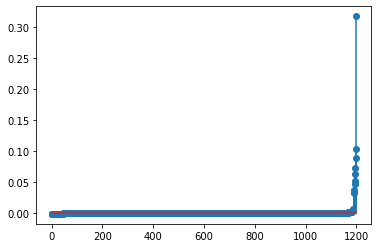

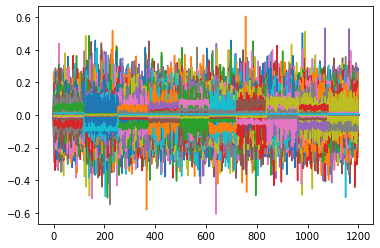

-0.00068210496


In [4]:
tol = tf.constant(1e-8)
kl = tf.math.multiply(K,Ky) #mult elemento a elemento
N = tf.shape(kl)[0]
N2 = tf.cast(tf.shape(kl)[0],dtype=tf.float32)
h = tf.eye(N) - (1.0/N2)*tf.ones([N,1])*tf.ones([1,N]) #matrix for centered kernel
kl = tf.matmul(tf.matmul(kl,h),tf.matmul(kl,h)) # H K\circ L H
kl = kl+tol*tf.eye(N) # obligar a que no tenga valores propios
kl = kl/tf.linalg.trace(kl) # obligar a que la suma de los valores propios sea 1

plt.imshow(kl.numpy())
plt.colorbar()
plt.show()

print(tf.linalg.trace(kl).numpy())

val,vec = tf.linalg.eigh(kl) # val,_ = tf.linalg.eigh(kl) # solo val
val = tf.math.real(val) # imag ,obligar a tomar solo parte real 0.3 +j0.000000000001
vec = tf.math.real(vec)
plt.stem(val.numpy())
plt.show()
plt.plot(vec.numpy())
plt.show()

print(tf.math.reduce_min(val).numpy())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


<StemContainer object of 3 artists>

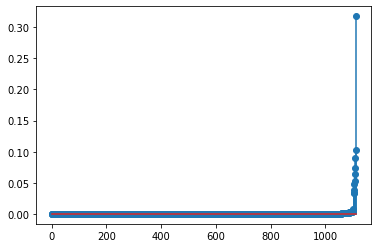

In [5]:
val2 = tf.where(val > tol)
#tf.math.reduce_min(val2)
plt.stem(val[val>tol].numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


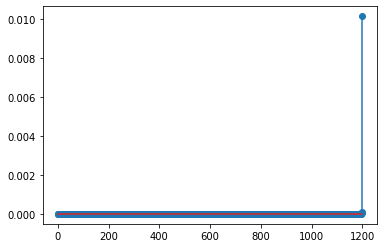

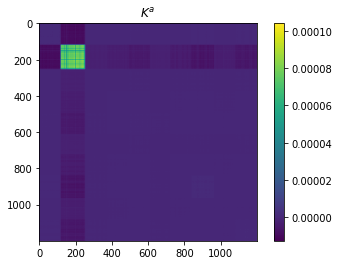

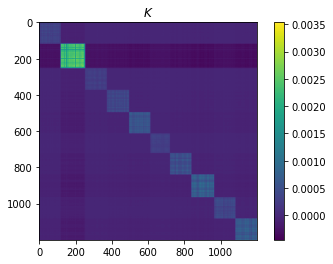

1.5168048


In [6]:
alpha = tf.convert_to_tensor(4.01,dtype=tf.float32)
val2 = tf.math.pow(tf.linalg.diag(val+tol+tf.math.abs(tf.math.reduce_min(val))),alpha)

plt.stem(tf.linalg.diag_part(val2).numpy())
plt.show()
#knor = tf.tensordot(tf.tensordot(vec,val2 ,axes=1),tf.transpose(vec),axes=1)
knor = tf.matmul(tf.matmul(vec,val2),tf.transpose(vec))
plt.imshow(knor.numpy())
plt.title('$K^a$')
plt.colorbar()
plt.show()
plt.imshow(kl.numpy())
plt.title('$K$')
plt.colorbar()
plt.show()
#tf.linalg.diag(val).shape
cositl =  (1.0/(1.0-alpha))*tf.math.log(tf.linalg.trace(knor))
print(cositl.numpy())

In [0]:
# Define custom loss
#centered kernel alignmet
#http://www.jmlr.org/papers/volume13/cortes12a/cortes12a.pdf
#https://www.frontiersin.org/articles/10.3389/fnins.2017.00550/full
def custom_loss(scale=5):
    #@tf.function()  #decorador para operar sobre python, mas lento y poco efectivo en muchos casos
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def custom_cka_loss(y_true,y_pred): #ytrue labels, ypred  = phi(Xw+0), phi(Xw) = Xw (activation = linear, bias = false)
      #kernels###############################################
      scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=scale)
      scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=1e-13)
      k = scalar_kernel.matrix(y_pred, y_pred)
      l = scalar_kernely.matrix(y_true, y_true)
      #centralizar#####################################################
      N = tf.shape(l)[0]
      N2 = tf.cast(tf.shape(l)[0],dtype=tf.float32)
      h = tf.eye(N) - (1.0/N2)*tf.ones([N,1])*tf.ones([1,N]) #matrix for centered kernel
      trkl = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(l,h)))
      trkk = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(k,h)))
      trll = tf.linalg.trace(tf.matmul(tf.matmul(l,h),tf.matmul(l,h)))
      #####funcion de costo############################################3
      f     = -trkl/tf.sqrt(trkk*trll)# negative cka cost function (minimizing) f \in [-1,0]
      return f
    # Return a function
    return custom_cka_loss

# Define custom loss
#centered kernel alignmet
#http://www.jmlr.org/papers/volume13/cortes12a/cortes12a.pdf
#https://www.frontiersin.org/articles/10.3389/fnins.2017.00550/full
def custom_loss2(scale=5,alpha=2):
    #@tf.function()  #decorador para operar sobre python, mas lento y poco efectivo en muchos casos
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def custom_itl_loss(y_true,y_pred): #ytrue labels, ypred  = phi(Xw+0), phi(Xw) = Xw (activation = linear, bias = false)
      #kernels###############################################
      alphatf = tf.convert_to_tensor(alpha,dtype=tf.float32)
      tol = tf.constant(1e-5) #evitar valores propios cercanos a cero

      scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=scale)
      scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=1e-13)
      
      k = scalar_kernel.matrix(y_pred, y_pred)
      l = scalar_kernely.matrix(y_true, y_true)
      kl = tf.math.multiply(k,l)
      #centralizar#####################################################
      N = tf.shape(l)[0]
      N2 = tf.cast(tf.shape(l)[0],dtype=tf.float32)
      h = tf.eye(N) - (1.0/N2)*tf.ones([N,1])*tf.ones([1,N]) #matrix for centered kernel
      k = tf.matmul(tf.matmul(k,h),tf.matmul(k,h))
      kl = tf.matmul(tf.matmul(kl,h),tf.matmul(kl,h))
      #regularizar
      k = k +tol*tf.eye(N)
      kl = kl +tol*tf.eye(N)
      #asegurar trace uno
      k = k/tf.linalg.trace(k)
      #l = l/tf.linalg.trace(l)
      kl = kl/tf.linalg.trace(k)
      #vectores y valores propios
      valkl,_ = tf.linalg.eigh(kl)
      valk,_ = tf.linalg.eigh(k)
      #asegurar  valores y vectores propios reales
      valkl = tf.math.real(valkl)
      valk = tf.math.real(valk)
            
      return   (1.0/(1.0-alphatf))*tf.math.log(tf.math.reduce_sum(tf.math.pow(valkl[valkl > tol],alphatf))/tf.math.reduce_sum(tf.math.pow(valk[valk>tol],alphatf)))
    # Return a function
    return custom_itl_loss

$$tr(K(W)^\alpha) = tr(V_K (\Delta + \lambda I) ^\alpha V_K^\top)$$

$$S_\alpha(L|K(W)) = \frac{1}{1-\alpha}\log\left(tr\left((L\circ K(W)\right)^\alpha)\right)-\frac{1}{1-\alpha}\log\left(tr\left(K(W)\right)^\alpha)\right)$$

$$S_\alpha(L|K(W)) = \frac{1}{1-\alpha}\log\left(tr\left(K_L(W)^\alpha\right)/tr\left(K(W)^\alpha\right)\right)$$

$$S_\alpha(L|K(W)) = \frac{1}{1-\alpha}\log\left(tr\left((V_{KL}\Delta_{KL}V_{KL}^\top)^\alpha\right)/tr\left((V_{K}\Delta_{K}V_{K}^\top)^\alpha\right)\right)$$

$$S_\alpha(L|K(W)) = \frac{1}{1-\alpha}\log\left(tr\left(V_{KL}\Delta_{KL}^\alpha V_{KL}^\top\right)/tr\left(V_{K}\Delta_{K}^\alpha V_{K}^\top\right)\right)$$

$$tr(A)=\sum^N_{i=1} \lambda_i$$

$$tr(A^\alpha)=\sum^N_{i=1} \lambda_i^\alpha$$

$$S_\alpha(L|K(W)) = \frac{1}{1-\alpha}\log\left(\frac{\sum^N_{i=1}(\lambda^{KL}_i)^\alpha}{\sum^N_{i=1}(\lambda^{K}_i)^\alpha}\right)$$





# modelo de keras con funcion de costo propia

In [8]:
#ejemplo funcional
tf.keras.backend.clear_session()
Q1 = 100
l1 = 1e-3
l2 = 1e-3
inputA= tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entradaA')
flattenA = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(inputA)
#h1 = tf.keras.layers.Dense(50,activation="tanh")(flattenA)
output = tf.keras.layers.Dense(Q1,activation="linear",use_bias=False,
                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),
                                name='outC_cka')(flattenA) #salida rotacion Lineal con cka
model_fun = tf.keras.Model(inputs=[inputA],outputs=[output])
model_fun.summary()
tf.keras.utils.plot_model(model_fun)

#compilar modelo y entrenar con funcion propia de perdida

model_fun.compile(loss=[custom_loss2(scale=5,alpha = 2)], 
              #loss_weights = [0.1,0.1,0.8],
              optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4))#,
              #metrics=["accuracy"]) #f1, precision, recall, crossentropy
history = model_fun.fit(x =Xtrain, y=ytrain, 
                        epochs=20,batch_size=256, # 32, 64, 128, 256
                         validation_split=0.3)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
entradaA (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
outC_cka (Dense)             (None, 100)               78400     
Total params: 78,400
Trainable params: 78,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
165/165 [==============================] - 9s 52ms/step - loss: -15.5189 - val_loss: -16.5557
Epoch 2/20
165/165 [==============================] - 8s 48ms/step - loss: -17.1213 - val_loss: -17.1212
Epoch 3/20
165/165 [==============================] - 8s 48ms/step - loss: -17.4863 - val_loss: -17.3899
Epoch 4/20
165/165 [==============================] - 8s 48ms/step - los

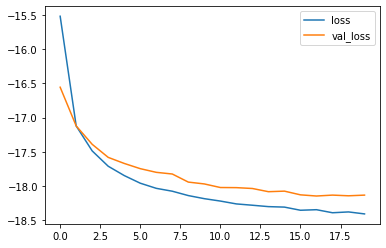

In [9]:
import pandas as pd
hpd = pd.DataFrame(history.history)
#hpd.plot()
#plt.show()
hpd[['loss','val_loss']].plot()
plt.show()

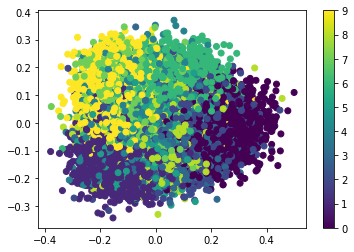

In [10]:
from sklearn.decomposition import PCA
zitl = PCA().fit_transform(model_fun.predict(Xtrain))
plt.scatter(zitl[:,0],zitl[:,1],c=ytrain)
plt.colorbar()
plt.show()

In [0]:
#plot mnist 2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def plot_mnist_2d(Z,y,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(16,10))
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()
      

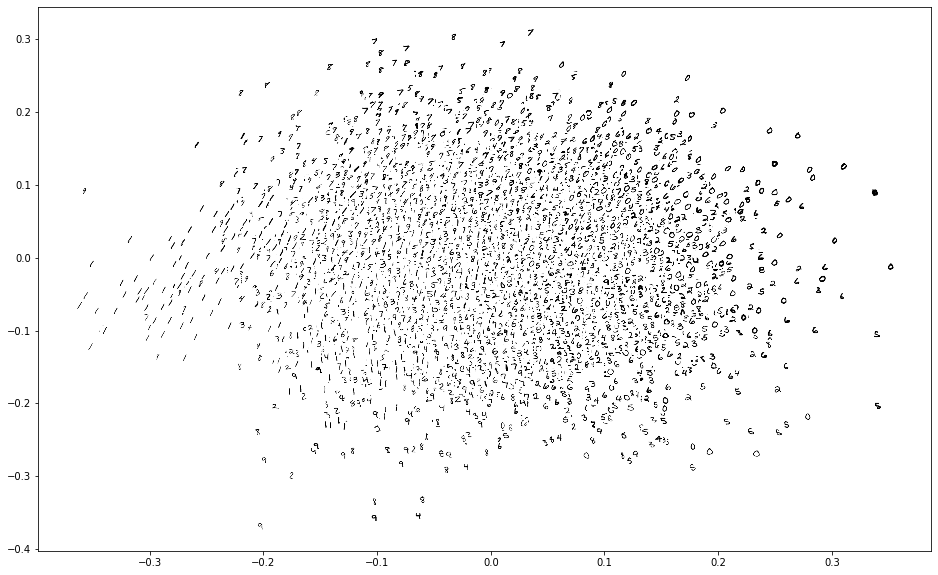

In [0]:
Ni =5000
ind = np.random.randint(0,ytrain.shape[0],Ni)
plot_mnist_2d(zitl[ind],ytrain[ind],Xtrain[ind],img_w=28,img_h=28,zoom=0.3,cmap='binary')


# Wrapper con keras y sklearn





In [0]:
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import StratifiedShuffleSplit

class Keras_CKA(BaseEstimator, TransformerMixin):
  def __init__(self,epochs=25,batch_size=128,Q=10,learning_rate=1e-3,optimizer='Adam',
                l1_param=1e-3,l2_param=1e-3,validation_split=0.2,verbose=1,scale=5,alpha=2,ml='cka'):
        self.epochs = epochs
        self.scale = scale
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l2_param
        self.alpha=alpha
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.ml = ml
        self.Q=Q
        
  # Define custom loss
  def custom_loss(self):
    #@tf.function()  #decorador para operar sobre python, mas lento y poco efectivo en muchos casos
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def custom_cka_loss(y_true,y_pred): #ytrue labels, ypred  = Xw
      #kernels###############################################
      scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=self.scale)
      scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=1e-13)
      k = scalar_kernel.matrix(y_pred, y_pred)
      l = scalar_kernely.matrix(y_true, y_true)
      #centralizar#####################################################
      N = tf.shape(l)[0]
      N2 = tf.cast(tf.shape(l)[0],dtype=tf.float32)
      h = tf.eye(N) - (1.0/N2)*tf.ones([N,1])*tf.ones([1,N]) #matrix for centered kernel
      trkl = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(l,h)))
      trkk = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(k,h)))
      trll = tf.linalg.trace(tf.matmul(tf.matmul(l,h),tf.matmul(l,h)))
      #####funcion de costo############################################3
      f     = -trkl/tf.sqrt(trkk*trll)# negative cka cost function (minimizing) f \in [-1,0]
      return f
    # Return a function
    return custom_cka_loss
  def custom_loss2(self):
    #@tf.function()  #decorador para operar sobre python, mas lento y poco efectivo en muchos casos
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def custom_itl_loss(y_true,y_pred): #ytrue labels, ypred  = phi(Xw+0), phi(Xw) = Xw (activation = linear, bias = false)
      #kernels###############################################
      alphatf = tf.convert_to_tensor(self.alpha,dtype=tf.float32)
      tol = tf.constant(1e-5) #evitar valores propios cercanos a cero

      scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=self.scale)
      scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=1e-13)
      
      k = scalar_kernel.matrix(y_pred, y_pred)
      l = scalar_kernely.matrix(y_true, y_true)
      kl = tf.math.multiply(k,l)
      #centralizar#####################################################
      N = tf.shape(l)[0]
      N2 = tf.cast(tf.shape(l)[0],dtype=tf.float32)
      h = tf.eye(N) - (1.0/N2)*tf.ones([N,1])*tf.ones([1,N]) #matrix for centered kernel
      k = tf.matmul(tf.matmul(k,h),tf.matmul(k,h))
      kl = tf.matmul(tf.matmul(kl,h),tf.matmul(kl,h))
      #regularizar
      k = k +tol*tf.eye(N)
      kl = kl +tol*tf.eye(N)
      #asegurar trace uno
      k = k/tf.linalg.trace(k)
      #l = l/tf.linalg.trace(l)
      kl = kl/tf.linalg.trace(k)
      #vectores y valores propios
      valkl,_ = tf.linalg.eigh(kl)
      valk,_ = tf.linalg.eigh(k)
      #asegurar  valores y vectores propios reales
      valkl = tf.math.real(valkl)
      valk = tf.math.real(valk)
            
      return   (1.0/(1.0-alphatf))*tf.math.log(tf.math.reduce_sum(tf.math.pow(valkl[valkl > tol],alphatf))/tf.math.reduce_sum(tf.math.pow(valk[valk>tol],alphatf)))
    # Return a function
    return custom_itl_loss
  

  def fit(self,X,y):
    if self.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    elif self.optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
    else:
        opt=self.optimizer
    
    tf.keras.backend.clear_session()
    ###acomodar arquitectura de red###### 
    inputA = tf.keras.layers.Input(shape=(X.shape[1],X.shape[2]), name='entradaA')
    flattenA = tf.keras.layers.Flatten(input_shape=(X.shape[1],X.shape[2]))(inputA) #no es siempre necesario, para imagenes se usa
    outputC = tf.keras.layers.Dense(self.Q,activation="linear",use_bias=False,
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param),
                                    name='outC_cka')(flattenA) #salida rotacion Lineal con cka entrada inputA para EEG

    self.model = tf.keras.Model(inputs=[inputA],outputs=[outputC])
    if self.ml == 'cka':
        loss = self.custom_loss()
    else: loss = self.custom_loss2()  #itl  
    self.model.compile(loss=loss, optimizer=opt, metrics = "accuracy")
    self.history = self.model.fit(x =X, y=y,epochs=self.epochs,batch_size=self.batch_size, # 32, 64, 128, 256
                         validation_split=self.validation_split,verbose=5) #gradeinte auto optimizado con tf
    
  def transform(self, X, *_):
    return  self.model.predict(X) # XW_cka  {renyi itl}
  def fit_transform(self,X,y):
      self.fit(X,y)
      return  self.transform(X)
  def plot_history_acc_w(self):
      plt.plot(self.history.history['loss'],label='loss')
      plt.plot(self.history.history['val_loss'],label='val_loss')
      plt.legend()
      return

Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25


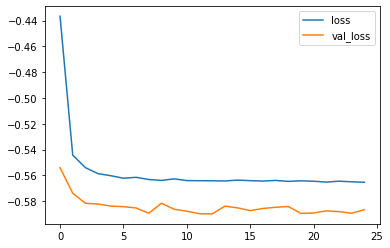

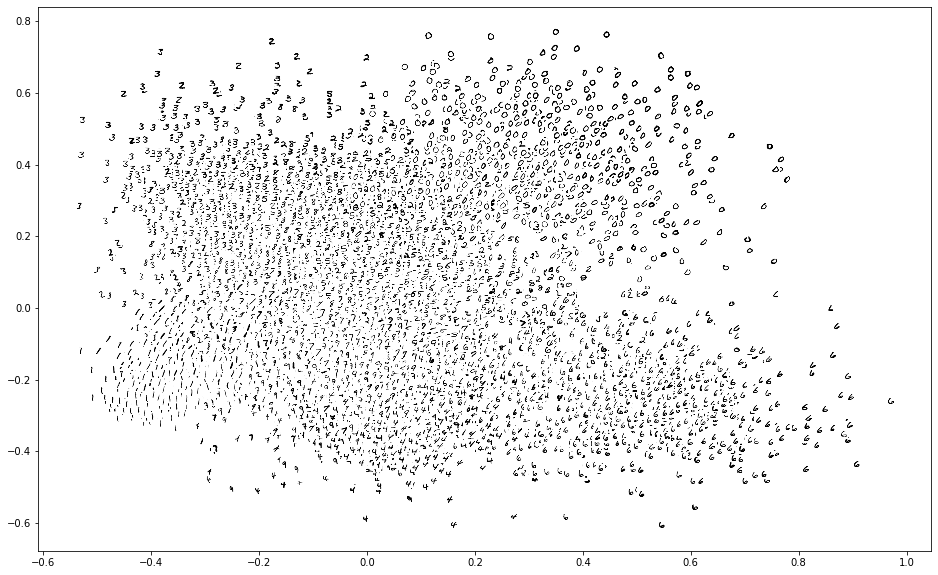

In [8]:
from sklearn.decomposition import PCA
red = Keras_CKA()
zcka = PCA(n_components=2).fit_transform(red.fit_transform(Xtrain,ytrain))
red.plot_history_acc_w()
plt.show()
Ni =10000
ind = np.random.randint(0,ytrain.shape[0],Ni)
plot_mnist_2d(zcka[ind],ytrain[ind],Xtrain[ind],img_w=28,img_h=28,zoom=0.3,cmap='binary')
plt.show()

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

steps = [('rep',Keras_CKA(ml='itl')),
         ('cla',SGDClassifier())]


parameters = {'rep__scale':[5],
              'rep__alpha':[1.01,2]}

gridsearch = GridSearchCV(Pipeline(steps), parameters,cv = 3,scoring="accuracy",verbose=20)
gridsearch.fit(Xtrain,ytrain)



Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] rep__alpha=1.01, rep__scale=5 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
[CV] ....... rep__alpha=1.01, rep__scale=5, score=0.467, total= 2.4min
[CV] rep__alpha=1.01, rep__scale=5 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s


Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
[CV] ....... rep__alpha=1.01, rep__scale=5, score=0.542, total= 2.3min
[CV] rep__alpha=1.01, rep__scale=5 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.7min remaining:    0.0s


Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
[CV] ....... rep__alpha=1.01, rep__scale=5, score=0.474, total= 2.3min
[CV] rep__alpha=2, rep__scale=5 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.0min remaining:    0.0s


Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
[CV] .......... rep__alpha=2, rep__scale=5, score=0.315, total= 2.3min
[CV] rep__alpha=2, rep__scale=5 ......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  9.3min remaining:    0.0s


Epoch 1/25
Epoch 2/25


**Prevenir ser desconectado de Google colab**\

1. Presionar la secuencia Crtl+Shift+i, a continuacion se desplegara una ventana adyacente, en dicha ventana buscar y posteriormente hacer click en la seccion Consola o Console.
2. Una vez allí, en la parte final de la ventana podrá observar un cuadro de texto, por favor introducir el siguiente codigo:
\

```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000) 
```
3. Presione posteriormente Enter, luego deberá observar un mensaje que dice "working", en caso de un error introducir el siguiente codigo:
\

```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect,60000)
```
